# C&W Attack

In [1]:
import os

### Import related libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16

In [10]:
BATCH_SIZE = 8
ITERATIONS = 100

### Data Preparation

In [4]:
def preprocess(image, label):
    return tf.cast(image, dtype=tf.float32)/255, label

train_data = tfds.load("stl10", split="train", as_supervised=True, shuffle_files=False, data_dir="./data")
train_data = train_data.map(preprocess).batch(BATCH_SIZE)

label_map = ['plane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'primate', 'boat', 'truck']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling data/stl10/1.0.0.incompleteTCYBY6/stl10-train.tfrecord*...:   0%|          | 0/5000 [00:00<?, ? exam…

Generating test examples...:   0%|          | 0/8000 [00:00<?, ? examples/s]

Shuffling data/stl10/1.0.0.incompleteTCYBY6/stl10-test.tfrecord*...:   0%|          | 0/8000 [00:00<?, ? examp…

Generating unlabelled examples...:   0%|          | 0/100000 [00:00<?, ? examples/s]

Shuffling data/stl10/1.0.0.incompleteTCYBY6/stl10-unlabelled.tfrecord*...:   0%|          | 0/100000 [00:00<?,…

Dataset stl10 downloaded and prepared to ./data/stl10/1.0.0. Subsequent calls will reuse this data.


### Model Architecture

분류기 모델의 아키텍쳐는 다음과 같습니다. 이 모델의 학습은 [pretraining](./pretraining.ipynb) 코드를 참고하길 바랍니다.

In [5]:
class Classifier(models.Model):

    def __init__(self, num_classes=10):
        super(Classifier, self).__init__()

        self.num_classes = num_classes

        self.vgg = VGG16(include_top=False, weights="imagenet")
        self.classifier = models.Sequential([
            layers.GlobalAveragePooling2D(),
            layers.Dense(num_classes)
        ])

    def call(self, x):
        f = self.vgg(x)
        logits = self.classifier(f)
        return logits

저장된 모델을 불러옵니다.

In [6]:
from google.colab import drive
drive.mount('/content/drive')
classifier = tf.saved_model.load("drive/MyDrive/Test/LIG/checkpoints/classifier/")

Mounted at /content/drive


## $L_2$ C&W Attack

In [7]:
def f_function(logits, t):
    """
    Perturbation objective 계산

    Arguments:
    ----------
    - logits: 분류기가 image_fake를 입력으로 받아 계산한 logits
    - t: target class. 무슨 클래스로 분류되도록 perturbation을 줄 것인지

    Returns:
    --------
    - f: f value
    """

    f = tf.nn.relu(tf.math.reduce_max(logits, keepdims=True) - logits[:, t])
    return f


def l2_objective(image_real, image_fake, logits, t, c=1.0):
    """
    objective + 계산

    Arguments:
    ----------
    - image_real: original image (1, H, W, 3)
    - image_fake: perturbed image (1, H, W, 3)
    - logits: 분류기가 image_fake를 입력으로 받아 계산한 logits
    - t: target class. 무슨 클래스로 분류되도록 perturbation을 줄 것인지
    - c: perturbation coefficient

    Returns:
    --------
    - loss: loss value
    """

    l2_dist = tf.reduce_mean((image_real - image_fake)**2)
    f = f_function(logits, t)
    return l2_dist + c*f


def get_initial_w(image):
    """
    image를 w로 reparameterize.
    image = 0.5 * (tanh(w) + 1) 식으로 w 계산

    Arguments:
    ----------
    - image: Reparameterize 하고 싶은 이미지 (1, H, W, 3)

    Returns:
    --------
    - w: initial w 값
    """

    w = tf.math.atanh(2 * image - 1)
    w = tf.Variable(w, trainable=True)
    return w


def compute_image(w):
    """
    w로 image 복원
    image = 0.5 * (tanh(w) + 1)

    Arguments:
    ----------
    - w: w 값

    Returns:
    --------
    - image: 복원된 이미지
    """

    return (tf.math.tanh(w) + 1)/2


def cw_l2_attack(model, image_real, t, iterations=100):
    """
    L2 C&W attack

    Arguments:
    ----------
    - model: 분류기
    - image_real: perturbation 주고 싶은 원본 이미지
    - t: target class. 무슨 클래스로 분류되도록 perturbation을 줄 것인지
    - iterations: perturbation 횟수

    Returns:
    --------
    - image: perturbed image
    """
    
    w = get_initial_w(image_real)
    optimizer = optimizers.Adam()

    for i in range(iterations):
        with tf.GradientTape() as tape:
            tape.watch(w)
            image_fake = compute_image(w)
            logits, ps = model(image_fake)
            loss = l2_objective(image_real, image_fake, logits, t)

        gradients = tape.gradient(loss, [w])
        optimizer.apply_gradients(zip(gradients, [w]))

    return compute_image(w)


def predict(model, image):
    pred = model(image)[0]
    pred = tf.argmax(pred, axis=-1)
    return pred

True label / prediction


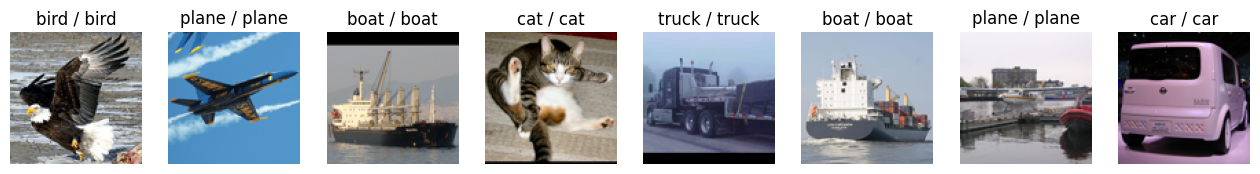

In [8]:
image, label = next(iter(train_data))
pred = predict(classifier, image)

print("True label / prediction")
plt.figure(figsize=(16, 3))
for i in range(len(image)):
    plt.subplot(1, len(image), i + 1)
    plt.imshow(image.numpy()[i])
    plt.axis("off")
    plt.title(f"{label_map[label.numpy()[i]]} / {label_map[pred.numpy()[i]]}")

plt.show()

In [13]:
image_fake = cw_l2_attack(classifier, image, t=9, iterations=100)

True label / prediction


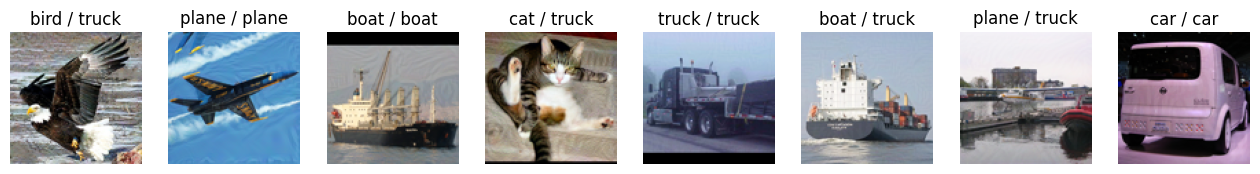

In [14]:
image, label = next(iter(train_data))
pred = predict(classifier, image_fake)

print("True label / prediction")
plt.figure(figsize=(16, 3))
for i in range(len(image_fake)):
    plt.subplot(1, len(image_fake), i + 1)
    plt.imshow(image_fake.numpy()[i])
    plt.axis("off")
    plt.title(f"{label_map[label.numpy()[i]]} / {label_map[pred.numpy()[i]]}")

plt.show()

## $L_0$ C&W Attack

In [15]:
def restore_pixel(original_image, perturbed_image, exclude_pixel_index):
    """
    Perturbation pixel 중 일부를 다시 원본 픽셀로 복원
    """

    N, H, W, C = original_image.shape

    original_image = original_image.reshape(N, H*W, C)
    perturbed_image = perturbed_image.reshape(N, H*W, C)

    for i in range(N):
        perturbed_image[i, exclude_pixel_index[i]] = original_image[i, exclude_pixel_index[i]]
        
    perturbed_image = perturbed_image.reshape(N, H, W, C)
    return perturbed_image


def cw_l0_attack(model, image, t, iterations, l2_iterations):
    """
    L0 C&W attack

    Arguments:
    ----------
    - model: 분류기
    - image_real: perturbation 주고 싶은 원본 이미지
    - t: target class. 무슨 클래스로 분류되도록 perturbation을 줄 것인지
    - iterations: l0 perturbation 횟수
    - l2_iterations: l2 perturbation 횟수

    Returns:
    --------
    - image: perturbed image
    """

    N, H, W, C = image.shape
    exclude_pixel_index = [[] for _ in range(N)]

    perturbed_image = image

    for i in range(iterations):
        # L2 attack
        perturbed_image = cw_l2_attack(model, perturbed_image, t, iterations=l2_iterations)
        perturbed_image = tf.Variable(perturbed_image, trainable=True)

        # 픽셀별 gradient 계산
        with tf.GradientTape() as tape:
            tape.watch(perturbed_image)
            logits, ps = model(perturbed_image)
            f = f_function(logits, t)

        # 채널방향으로 normalize (채널 없애기 위해)
        grads = tape.gradient(f, [perturbed_image])[0]
        grads = tf.sqrt(tf.reduce_sum(grads**2, axis=-1))

        perturbation = perturbed_image - image
        perturbation = tf.sqrt(tf.reduce_sum(perturbation**2, axis=-1))

        # gradienet 가장 작은 픽셀 위치 계산 후, perturbation  제외대상에 포함
        perturbation = tf.reshape(perturbation, shape=(N, H*W))
        grads = tf.reshape(grads, shape=(N, H*W))
        pixel_index = tf.argmin(grads * perturbation, axis=1)
        for i in range(N):
            exclude_pixel_index[i].append(pixel_index[i])

        image_np = image.numpy()
        perturbed_image_np = perturbed_image.numpy()

        # 제외픽셀은 원본픽셀로 복원
        perturbed_image_np = restore_pixel(image_np, perturbed_image_np, exclude_pixel_index)
        perturbed_image = tf.convert_to_tensor(perturbed_image_np)

    return perturbed_image

In [16]:
image_fake = cw_l0_attack(classifier, image, 9, iterations=10, l2_iterations=10)

True label / prediction


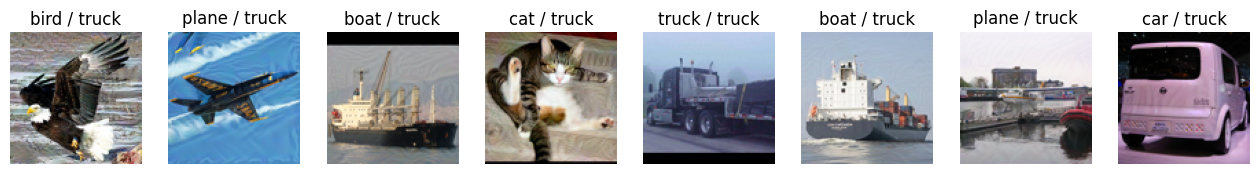

In [17]:
image, label = next(iter(train_data))
pred = predict(classifier, image_fake)

print("True label / prediction")
plt.figure(figsize=(16, 3))
for i in range(len(image_fake)):
    plt.subplot(1, len(image_fake), i + 1)
    plt.imshow(image_fake.numpy()[i])
    plt.axis("off")
    plt.title(f"{label_map[label.numpy()[i]]} / {label_map[pred.numpy()[i]]}")

plt.show()

## $L_{\infty}$ C&W Attack

In [ ]:
def cw_l_inf_attack(model, image, t, l2_iterations, threshold=None):
    """
    L0 C&W attack

    Arguments:
    ----------
    - model: 분류기
    - image_real: perturbation 주고 싶은 원본 이미지
    - t: target class. 무슨 클래스로 분류되도록 perturbation을 줄 것인지
    - l2_iterations: l2 perturbation 횟수
    - threshold: L_inf threshold

    Returns:
    --------
    - image: perturbed image
    """

    N, H, W, C = image.shape

    # 이미지별 제외 픽셀 리스트 초기화
    exclude_pixel_index = [[] for _ in range(N)]

    # L2 attack
    perturbed_image = cw_l2_attack(model, image, t, iterations=l2_iterations)

    # perturbation 계산
    perturbation = perturbed_image - image
    perturbation = tf.sqrt(tf.reduce_sum(perturbation**2, axis=-1))
    perturbation = tf.reshape(perturbation, shape=(N, H, W, 1))
    perturbation = perturbation.numpy()
    perturbation = np.tile(perturbation, [1, 1, 1, 3])

    image = image.numpy()
    perturbed_image = perturbed_image.numpy()

    # default threshold
    if threshold is None:
        threshold = perturbation.mean()
        
    # perturbation이 threshold보다 작은 픽셀은 원본픽셀로 복원
    perturbed_image[perturbation < threshold] = image[perturbation < threshold]
    return perturbed_image

In [ ]:
image_fake = cw_l_inf_attack(classifier, image, 9, ITERATIONS)

True label / prediction


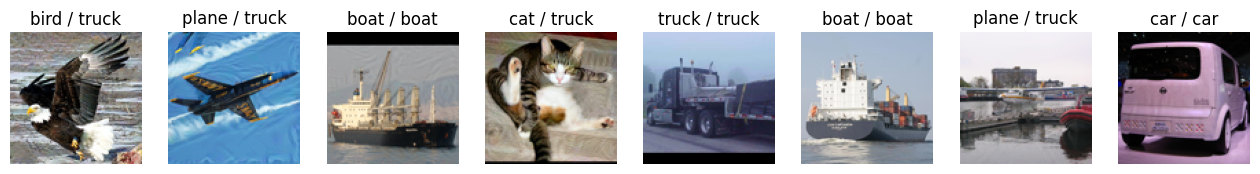

In [ ]:
image, label = next(iter(train_data))
pred = predict(classifier, image_fake)

print("True label / prediction")
plt.figure(figsize=(16, 3))
for i in range(len(image_fake)):
    plt.subplot(1, len(image_fake), i + 1)
    plt.imshow(image_fake[i])
    plt.axis("off")
    plt.title(f"{label_map[label.numpy()[i]]} / {label_map[pred.numpy()[i]]}")

plt.show()